<div style="text-align: right">Data Sci Engineering Methods and Tools </div>
<div style="text-align: right">Srinjoy Chakravarty, 30 October 2019</div>

# Blue is the Colour

Football is the world's most popular sport and of the most data-analyzed sports in Chelsea, you can make million pound salaries!

Next time you vist our home in London, you must go at least one home game at Stamford Bridge!

<br />
<center>
    <img src="robben_at_chelsea.jpg" width=2000 />
</center>

- "*I have two speeds. Fast and faster. I don't just run. I take it.*" - Arjen Robben (Chelsea Legend)

Maybe the more important aspect of this game is the individual nature of it. During an unstoppable inswinging **cross** from a winger like Robben, whoever is playing in defence has very little effect on whether or not the striker can score. 

Football stats consist of numerous metrics, some of them straightforward, some of them more advanced. Ball Possesion is an example of a straightforward metric but often has no real meaning. Teams with 70% possesion often pass sideways and backwards with little or no goal threat. In football, the goals per attacking cross into the box is probably a more insightful stat to define a ruthless an attacking team is.

- "*You have to surprise opponents, keep them guessing. Doing the same thing over and over again without variation will not work.*". - Arjen Robben (Who has a move named after him for doing it over and over)

# Research Question

A **Generative Model** is a model that ***generates*** data when given parameters as input. The parameters are values you'll need to generate a distribution. All our bayesian models so far have been generative.

The opposite of a generative model is a **discriminative** model. It does not generate data, it helps *discriminate* between two or more classes (or categories).

Can we **discriminate** (compare) two clubs based on their conversion rate of goals per cross? 

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Here are the stats for the Premier League in 2018/2019 season.

In [95]:
team_data = pd.read_csv("epl_team.csv")
pd.read_csv("epl_team.csv")

,Team,category,general_league_position,finance _live_games_televised,finance _tv_revenue,general_matches_played,general_won,general_draw,general_lost,attack_scored,...,defence_saves,defence_blocks,defence_interceptions,defence_tackles,defence_tackles_last_man,defence_clearances,defence_clearances_headed,defence_penalty_conceeded,attack_posession,attack_pass_accuracy
0,Manchester City,Champions League,1,26,150986355,38,32,2,4,95,...,58,63,362,518,0,543,295,4,64.0,89.0
1,Liverpool,Champions League,2,29,152425146,38,30,7,1,89,...,76,78,314,610,2,639,317,1,58.8,84.4
2,Chelsea,Champions League Qualification,3,25,146030216,38,21,9,8,63,...,85,73,351,618,2,593,330,2,59.9,87.6
3,Tottenham,Champions League Qualification,4,26,145230801,38,23,2,13,67,...,121,112,326,626,3,770,411,5,56.7,83.2
4,Arsenal,Europa League,5,25,142193180,38,21,7,10,73,...,133,118,412,609,2,762,404,7,56.1,83.3
5,Manchester United,Europa League,6,27,142512868,38,19,9,10,65,...,122,128,355,581,2,785,370,6,53.3,82.3
6,Wolverhampton,Europa League Qualification,7,15,127165114,38,16,9,13,47,...,100,148,501,720,2,824,464,4,47.4,78.2
7,Everton,No UEFA Competitions,8,18,128603905,38,15,9,14,54,...,94,85,456,700,4,825,430,5,51.0,77.3
8,Leicester,No UEFA Competitions,9,15,123328078,38,15,7,16,51,...,90,96,436,676,4,945,500,5,50.8,79.2
9,West Ham,No UEFA Competitions,10,16,122528663,38,15,7,16,52,...,148,141,457,723,5,855,397,5,49.0,78.7


## 1. Premier League Training

Let's take goals per cross average records from the 2018 premier league season.

### Latest Complete Season

A **prior** is the information that the model has ***before*** any observations. Let's assume that I know **nothing** about past premier league performances, and the only data I observed is the season 2018 stats. And I don't know what value range I should expect for the number of attacking goals from crosses. Based on this, how should I interpret the premier league stats? 

This is the **uniform distribution**:

Text(0, 0.5, 'Frequency')

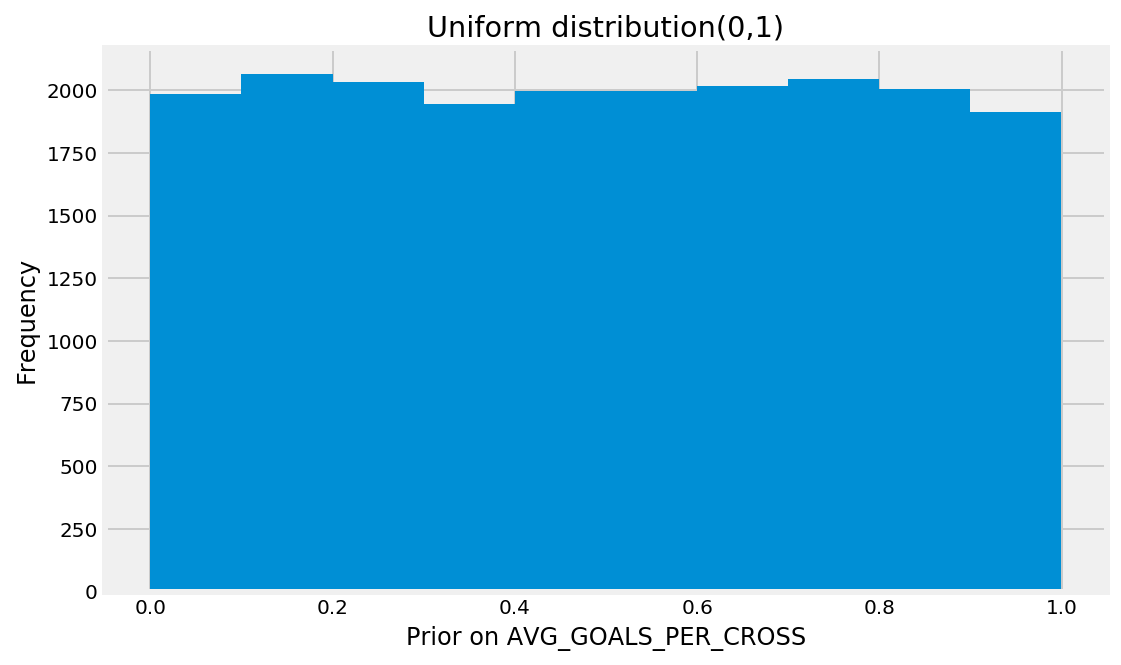

In [161]:
n_draw = 20000
prior_uniform_dist = pd.Series(np.random.uniform(0, 1, size = n_draw)) 
plt.figure(figsize=(8,5))
plt.hist(prior_uniform_dist)
plt.title('Uniform distribution(0,1)')
plt.xlabel('Prior on AVG_GOALS_PER_CROSS')
plt.ylabel('Frequency')

The **prior** represents our beliefs ***before we see the data***. In the above distribution, ***any probability is almost equally likely***. Thus this means I know nothing about the team, and I don’t even have any educated guess to make about the goals per cross (AVG_GOALS_PER_CROSS). 

Assume that 0.000 AVG_GOALS_PER_CROSS is equally like as 1.000 AVG_GOALS_PER_CROSS or any other probability between 0 and 1.

Let's scrape the 2018 season stats for Chelsea

In [162]:
chelsea = team_data.loc[[2]]
chelsea_goals = team_data.iloc[2].attack_scored
chelsea_crosses = team_data.iloc[2].attack_crosses
# adding a new calculated field called AVG_GOALS_PER_CROSS
chelsea['AVG_GOALS_PER_CROSS'] = chelsea_goals.astype(float) / chelsea_crosses.astype(float)
chelsea_key_attributes = chelsea[['attack_scored', 'attack_crosses', 'AVG_GOALS_PER_CROSS']]
chelsea_key_attributes

,attack_scored,attack_crosses,AVG_GOALS_PER_CROSS
2,63,692,0.09104


The data we observe says there was 692 attacking crosses, and 63 goals scored, hence an 0.09104 goals per cross average. 

This can be represented by a **binomial distribution**. A random variable $x$ that has a binomial distribution represents the number of successes (goals) in a sequence of $n$ independent hit/miss trials (crosses), each of which yields success with probability $p$. 

In case of this example, AVG_GOALS_PER_CROSS is the probability of success (average goals per cross between 0 - 1), attack_crosses is the number of crosses, and attack_scored is the number of goals.

## 2. A simplistic generative model for the posterior

Ricky Kim defines a simplistic generative model: Randomly pick one probability value from the uniform distribution above, and use this value as parameter for our generative model. 

Let's say the value we randomly pick is 0.230, this means 23% chance of a goal. If the result of the generative model matches the result we observed, then we keep the probability value 0.230 Otherwise we repeat generation until we finally get a distribution of probability that matches our observation. This becomes our **posterior**.

This generative model is even simpler than our Metropolis algorithm, and we will see that it mostly ***does not work***.

In [163]:
def posterior(num_crosses, k_goals, prior):
    hit = list()
    for p in prior:
        hit.append(np.random.binomial(num_crosses, p))
    posterior = prior[list(map(lambda x: x == k_goals, hit))]
    plt.figure(figsize=(80,50))
    plt.hist(posterior)
    plt.title('Posterior distribution')
    plt.xlabel('Posterior on AVG')
    plt.ylabel('Frequency')
    print('Number of draws left: %d, Posterior mean: %.3f, Posterior median: %.3f, Posterior 95%% quantile interval: %.3f-%.3f' % 
      (len(posterior), posterior.mean(), posterior.median(), posterior.quantile(.025), posterior.quantile(.975)))

defence_goals_conceeded = int(chelsea_key_attributes['attack_crosses'].astype(float))
general_matches_played = int(chelsea_key_attributes['attack_scored'].astype(float))

posterior(defence_goals_conceeded, general_matches_played, prior_uniform_dist)

Number of draws left: 35, Posterior mean: 0.090, Posterior median: 0.091, Posterior 95% quantile interval: 0.067-0.111


So we refined our **prior** to a **posterior**. That seemed to have worked.

The 95% quantile interval in the posterior distribution is called **credible interval**, and is to be contrasted to the **confidence interval** in the frequentist sense.

One major distinction between Bayesian's credible interval and Frequentist's confidence interval is their ***interpretation***: The Bayesian probability reflects a person’s **subjective** beliefs: The true parameter is inside a credible interval with measurable probability. This is appealing because it enables you to make a direct probability statement about parameters. Many people find this concept to be a more natural way of understanding a probability interval.

A **confidence interval**, on the other hand, enables you to make a claim that the interval covers the true parameter: If we gather a new sample, and calculate the confidence interval, and repeat this many times, 95% of those intervals we calculated will have true AVG_GOALS_PER_CROSS value within the interval.

- Credible Interval: "Given our observed data, there is a 95% probability that the true value of AVG_GOALS_PER_CROSS falls within the credible interval" 

- Confidence Interval: "There is a 95% probability that when I compute confidence interval from data of this sort, the true value of AVG_GOALS_PER_CROSS will fall within the confidence interval."

The credible interval is a statement of probability about the parameter value given fixed bounds. The confidence interval is a probability about the bounds given a fixed parameter value.

Often, what we would like to know is about the **true parameters**, not about the **bounds** of the parameters.

## 3. Older Seasons

Let's take premier league records from the older seasons when Robben was at his prime in Chelsea.

In [164]:
all_seasons_data = pd.read_csv("all_seasons.csv")
all_seasons_data
chelsea_2007 = all_seasons_data.loc[[1]]
chelsea_2008 = all_seasons_data.loc[[21]]

#### For 2007:

In [165]:
total_cross_2007 = int(chelsea_2007['total_cross'].astype(float))
goals_2007 = int(chelsea_2007['goals'].astype(float))
print(total_cross_2007)
print(goals_2007)
posterior(total_cross_2007, goals_2007, prior_uniform_dist)

897
64
Number of draws left: 17, Posterior mean: 0.074, Posterior median: 0.074, Posterior 95% quantile interval: 0.062-0.087


#### For 2008:

In [166]:
total_cross_2008 = int(chelsea_2008['total_cross'].astype(float))
goals_2008 = int(chelsea_2008['goals'].astype(float))
print(total_cross_2008)
print(goals_2008)
posterior(total_cross_2008, goals_2008, prior_uniform_dist)

945
65
Number of draws left: 23, Posterior mean: 0.075, Posterior median: 0.075, Posterior 95% quantile interval: 0.058-0.095


## 4. From regular season 2007 prior to regular season 2008 posterior

These are the regular season stats from 2007.

In [167]:
chelsea_2007

,team,wins,losses,goals,total_yel_card,total_red_card,total_scoring_att,ontarget_scoring_att,hit_woodwork,att_hd_goal,...,total_cross,corner_taken,touches,big_chance_missed,clearance_off_line,dispossessed,penalty_save,total_high_claim,punches,season
1,Chelsea,24.0,3.0,64.0,62.0,4.0,636.0,216.0,14.0,16.0,...,897.0,231.0,24010.0,NaN,2.0,NaN,1.0,74.0,22.0,2006-2007


and for 2008:

In [168]:
chelsea_2008

,team,wins,losses,goals,total_yel_card,total_red_card,total_scoring_att,ontarget_scoring_att,hit_woodwork,att_hd_goal,...,total_cross,corner_taken,touches,big_chance_missed,clearance_off_line,dispossessed,penalty_save,total_high_claim,punches,season
21,Chelsea,25.0,3.0,65.0,63.0,5.0,605.0,199.0,12.0,10.0,...,945.0,253.0,26290.0,NaN,8.0,687.0,0.0,62.0,19.0,2007-2008


If we take 2007 regular season stats for our prior, it is not a uniform distribution anymore.

The [Beta distribution](https://www.statlect.com/probability-distributions/beta-distribution) is a continuous probability distribution with two parameters, $\alpha$ and $\beta$. One of its most common uses is to model one’s uncertainty about the probability of success of an experiment. 

In particular, the conditional distribution of $x$, conditional on having observed $k$ successes (goals) out of $n$ trials (crosses), is a Beta distribution with parameters $k+1$ as $\alpha$ and $n−k+1$ as $\beta$.


In [169]:
chelsea_2007.iloc[0].total_cross

897.0

In [170]:
chelsea_2007.iloc[0].goals

64.0

This is the beta distribution for Chelsea, given prior information from season 2007.

Text(0, 0.5, 'Frequency')

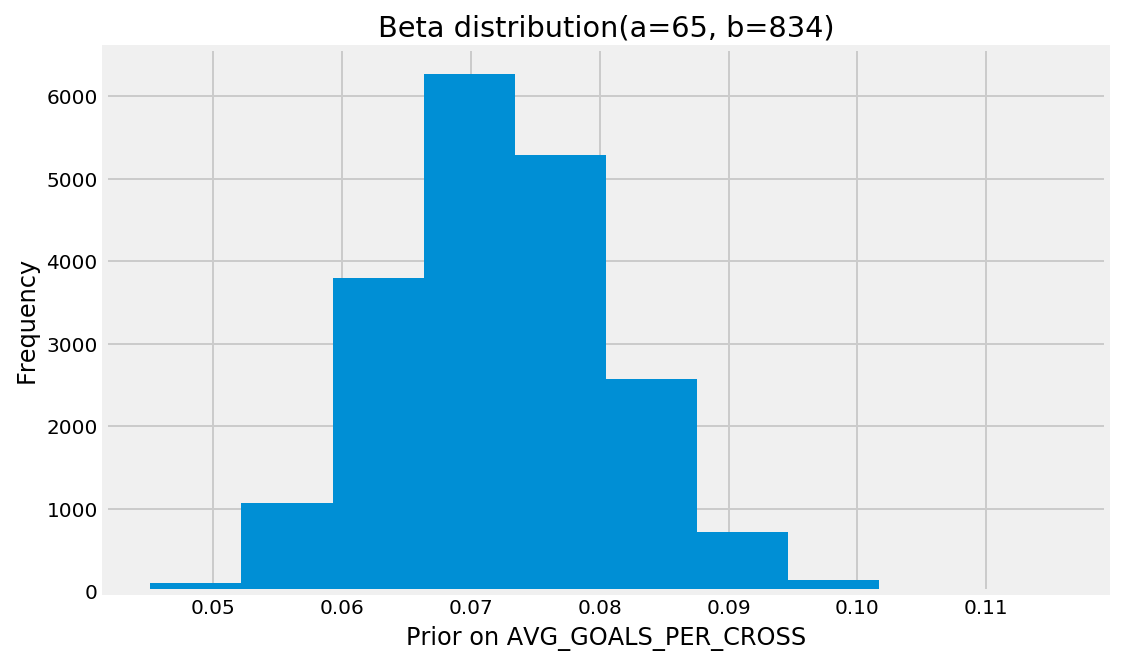

In [171]:
n_draw = 20000
prior_cross = int(chelsea_2007.iloc[0].total_cross)
prior_goals = int(chelsea_2007.iloc[0].goals)
prior_i = pd.Series(np.random.beta(prior_goals + 1, prior_cross - prior_goals + 1, size = n_draw)) 
plt.figure(figsize=(8,5)) 
plt.hist(prior_i)
plt.title('Beta distribution(a=%d, b=%d)' % (prior_goals + 1, prior_cross - prior_goals + 1))
plt.xlabel('Prior on AVG_GOALS_PER_CROSS')
plt.ylabel('Frequency')

Can we try to use this information to get the posterior for season 2008 using our simplistic `posterior()` function previously defined?

In [175]:
posterior(total_cross_2008, goals_2008, prior_i)

Number of draws left: 730, Posterior mean: 0.071, Posterior median: 0.071, Posterior 95% quantile interval: 0.059-0.082


It worked! Let's try an even more powerful function, like `NUTS` from `pymc3`.

Let's generate observations according to total crosses and goals for 2008:

In [181]:
def observed_data_generator(num_cross_try, observed_goal_data):
    result = np.ones(observed_goal_data)
    misses = num_cross_try - observed_goal_data
    result = np.append(result, np.zeros(misses))
    return result

In [229]:
goals_observed = observed_data_generator(total_cross_2008, goals_2008)

Let's plug those into a pymc3 model and generate the posterior.

In [208]:
import pymc3 as pm
with pm.Model() as model_1:    
    prior_mean = pm.Beta('AVG_GOALS_PER_CROSS', prior_goals + 1, prior_cross - prior_goals + 1)
    SUCCESS_PROB = pm.Bernoulli('SUCCESS_PROB', p = prior_mean, observed = goals_observed)  
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [AVG_GOALS_PER_CROSS]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:07<00:00, 2747.85draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f95108bfc88>],
      dtype=object)

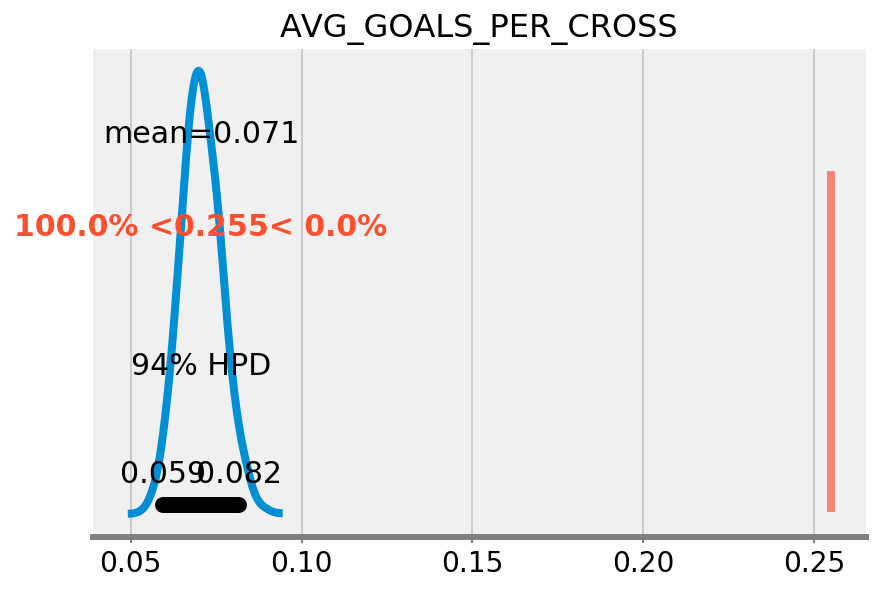

In [209]:
pm.plot_posterior(trace, var_names = ['AVG_GOALS_PER_CROSS'], ref_val=0.255)

The 94% quantile region has been narrowed compared to our posterior with the uniform prior.  

We are 94% certain that the true AVG_GOALS_PER_CROSS of Chelsea FC will lie between 0.059 and 0.082. We need more data to narrow our region of credibility.

## 5. Increasing observations

For this scenario, let's conjoin stats from premier league seasons 2007 and 2008. 

In [131]:
# vertically stacking chelsea's 2 seasons.

chelsea_dual_season = pd.concat([chelsea_2007, chelsea_2008], axis=0)
chelsea_dual_season

,team,wins,losses,goals,total_yel_card,total_red_card,total_scoring_att,ontarget_scoring_att,hit_woodwork,att_hd_goal,...,total_cross,corner_taken,touches,big_chance_missed,clearance_off_line,dispossessed,penalty_save,total_high_claim,punches,season
1,Chelsea,24.0,3.0,64.0,62.0,4.0,636.0,216.0,14.0,16.0,...,897.0,231.0,24010.0,NaN,2.0,NaN,1.0,74.0,22.0,2006-2007
21,Chelsea,25.0,3.0,65.0,63.0,5.0,605.0,199.0,12.0,10.0,...,945.0,253.0,26290.0,NaN,8.0,687.0,0.0,62.0,19.0,2007-2008


In [200]:
chelsea_crosses_2007_and_2008 =  pd.to_numeric(chelsea_dual_season.total_cross).astype(np.int64).sum()
chelsea_crosses_2007_and_2008

1842

In [201]:
chelsea_goals_2007_and_2008 = pd.to_numeric(chelsea_dual_season.goals).astype(np.int64).sum()
chelsea_goals_2007_and_2008

129

In [202]:
chelsea_observed_2007_2008 = observed_data_generator(chelsea_crosses_2007_and_2008, chelsea_goals_2007_and_2008)

In [210]:
import pymc3 as pm
with pm.Model() as model_2:    
    prior_mean_2007_2008 = pm.Beta('AVG_GOALS_PER_CROSS_2007_2008', chelsea_goals_2007_and_2008 + 1, chelsea_crosses_2007_and_2008 - chelsea_goals_2007_and_2008 + 1)    
    SUCCESS_PROB_2007_2008 = pm.Bernoulli('SUCCESS_PROB_2007_2008', p = prior_mean_2007_2008, observed = chelsea_observed_2007_2008)   
    trace_2007_2008 = pm.sample(10000, start=start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [AVG_GOALS_PER_CROSS_2007_2008]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:08<00:00, 2442.95draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f951152c438>],
      dtype=object)

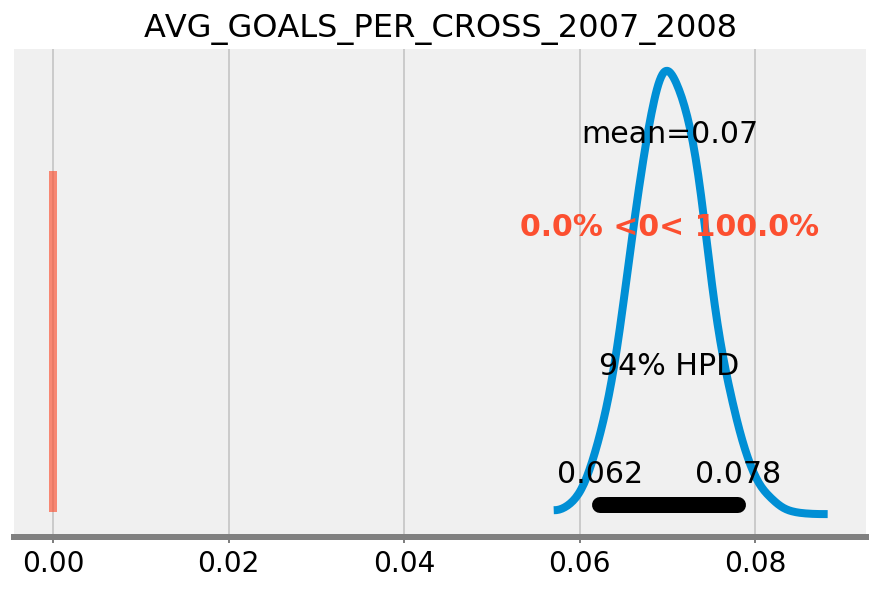

In [211]:
pm.plot_posterior(trace_2007_2008, var_names = ['AVG_GOALS_PER_CROSS_2007_2008'], ref_val=0)

Now I can say that I am 94% certain that the true goals per cross average of Chelsea FC lies between 0.062 and 0.078. The credible interval is narrower than before with increased observations...hurray!

## 6. Comparing Fulham over two seasons

I wanted to do a bit of analysis on Fulham as they are our nasty city rivals down at Craveen Cottage!
I wanted to compare Fulham over two seasons and see which season was better in terms of converting crosses i.e. average goals per cross. The data I observe are results from the premier league season of 2018, and the prior knowledge I have is from the 'older Lomana LuaLua days' of 2007 and 2008!

</br>

<center>
    <img src="fulham.jpg" width=2000 />
</center>

We leverage pymc3.

In [241]:
fulham_2007 = all_seasons_data.loc[[18]]
fulham_2007

,team,wins,losses,goals,total_yel_card,total_red_card,total_scoring_att,ontarget_scoring_att,hit_woodwork,att_hd_goal,...,total_cross,corner_taken,touches,big_chance_missed,clearance_off_line,dispossessed,penalty_save,total_high_claim,punches,season
18,Fulham,8.0,15.0,38.0,56.0,3.0,451.0,142.0,8.0,8.0,...,895.0,173.0,18720.0,NaN,6.0,NaN,1.0,45.0,22.0,2006-2007


In [242]:
fulham_2008 = all_seasons_data.loc[[38]]
fulham_2008

,team,wins,losses,goals,total_yel_card,total_red_card,total_scoring_att,ontarget_scoring_att,hit_woodwork,att_hd_goal,...,total_cross,corner_taken,touches,big_chance_missed,clearance_off_line,dispossessed,penalty_save,total_high_claim,punches,season
38,Fulham,8.0,18.0,38.0,55.0,6.0,469.0,154.0,7.0,7.0,...,849.0,183.0,21259.0,NaN,4.0,589.0,0.0,55.0,27.0,2007-2008


In [243]:
fulham_number_of_crosses_2007 = int(fulham_2007.iloc[0].total_cross)
print("fulham_number_of_crosses_2007: " + str(fulham_number_of_crosses_2007))
fulham_k_goals_2007 = int(fulham_2007.iloc[0].goals)
print("fulham_goals_2007: " + str(fulham_k_goals_2007))
fulham_number_of_crosses_2008 = int(fulham_2008.iloc[0].total_cross)
print("fulham_number_of_crosses_2008: " + str(fulham_number_of_crosses_2008))
fulham_k_goals_2008 = int(fulham_2008.iloc[0].goals)
print("fulham_goals_2008: " + str(fulham_k_goals_2008))

fulham_number_of_crosses_2007: 895
fulham_goals_2007: 38
fulham_number_of_crosses_2008: 849
fulham_goals_2008: 38


In [244]:
fulham_dual_prior = pd.concat([fulham_2007, fulham_2008], axis=0)
fulham_dual_prior

,team,wins,losses,goals,total_yel_card,total_red_card,total_scoring_att,ontarget_scoring_att,hit_woodwork,att_hd_goal,...,total_cross,corner_taken,touches,big_chance_missed,clearance_off_line,dispossessed,penalty_save,total_high_claim,punches,season
18,Fulham,8.0,15.0,38.0,56.0,3.0,451.0,142.0,8.0,8.0,...,895.0,173.0,18720.0,NaN,6.0,NaN,1.0,45.0,22.0,2006-2007
38,Fulham,8.0,18.0,38.0,55.0,6.0,469.0,154.0,7.0,7.0,...,849.0,183.0,21259.0,NaN,4.0,589.0,0.0,55.0,27.0,2007-2008


In [245]:
fulham_total_prior_crosses = pd.to_numeric(fulham_dual_prior.total_cross).sum()
fulham_total_prior_goals = pd.to_numeric(fulham_dual_prior.goals).sum()
print(fulham_total_prior_crosses)
print(fulham_total_prior_goals)

1744.0
76.0


In [246]:
fulham_2008_hit_miss_array = observed_data_generator(fulham_number_of_crosses_2008, fulham_k_goals_2008)
fulham_2007_hit_miss_array = observed_data_generator(fulham_number_of_crosses_2007, fulham_k_goals_2007)

In [247]:
import pymc3 as pm
with pm.Model() as model_a:    
    
    prior_mean_2008 = pm.Beta('2008_AVG_GOALS_PER_CROSS', fulham_total_prior_goals + 1, fulham_total_prior_crosses - fulham_total_prior_goals + 1)
    prior_mean_2007 = pm.Beta('2007_AVG_GOALS_PER_CROSS', fulham_total_prior_goals + 1, fulham_total_prior_crosses - fulham_total_prior_goals + 1)
        
    SUCCESS_PROB_2008 = pm.Bernoulli('2008_HIT_MISS', p = prior_mean_2008, observed = fulham_2008_hit_miss_array) 
    SUCCESS_PROB_2007 = pm.Bernoulli('2007_HIT_MISS', p = prior_mean_2007, observed = fulham_2007_hit_miss_array) 
    
    EvX = pm.Deterministic('EvX', prior_mean_2008 - prior_mean_2007)

    trace = pm.sample(10000, start=start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [2007_AVG_GOALS_PER_CROSS, 2008_AVG_GOALS_PER_CROSS]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:10<00:00, 2081.02draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9511432550>,
      dtype=object)

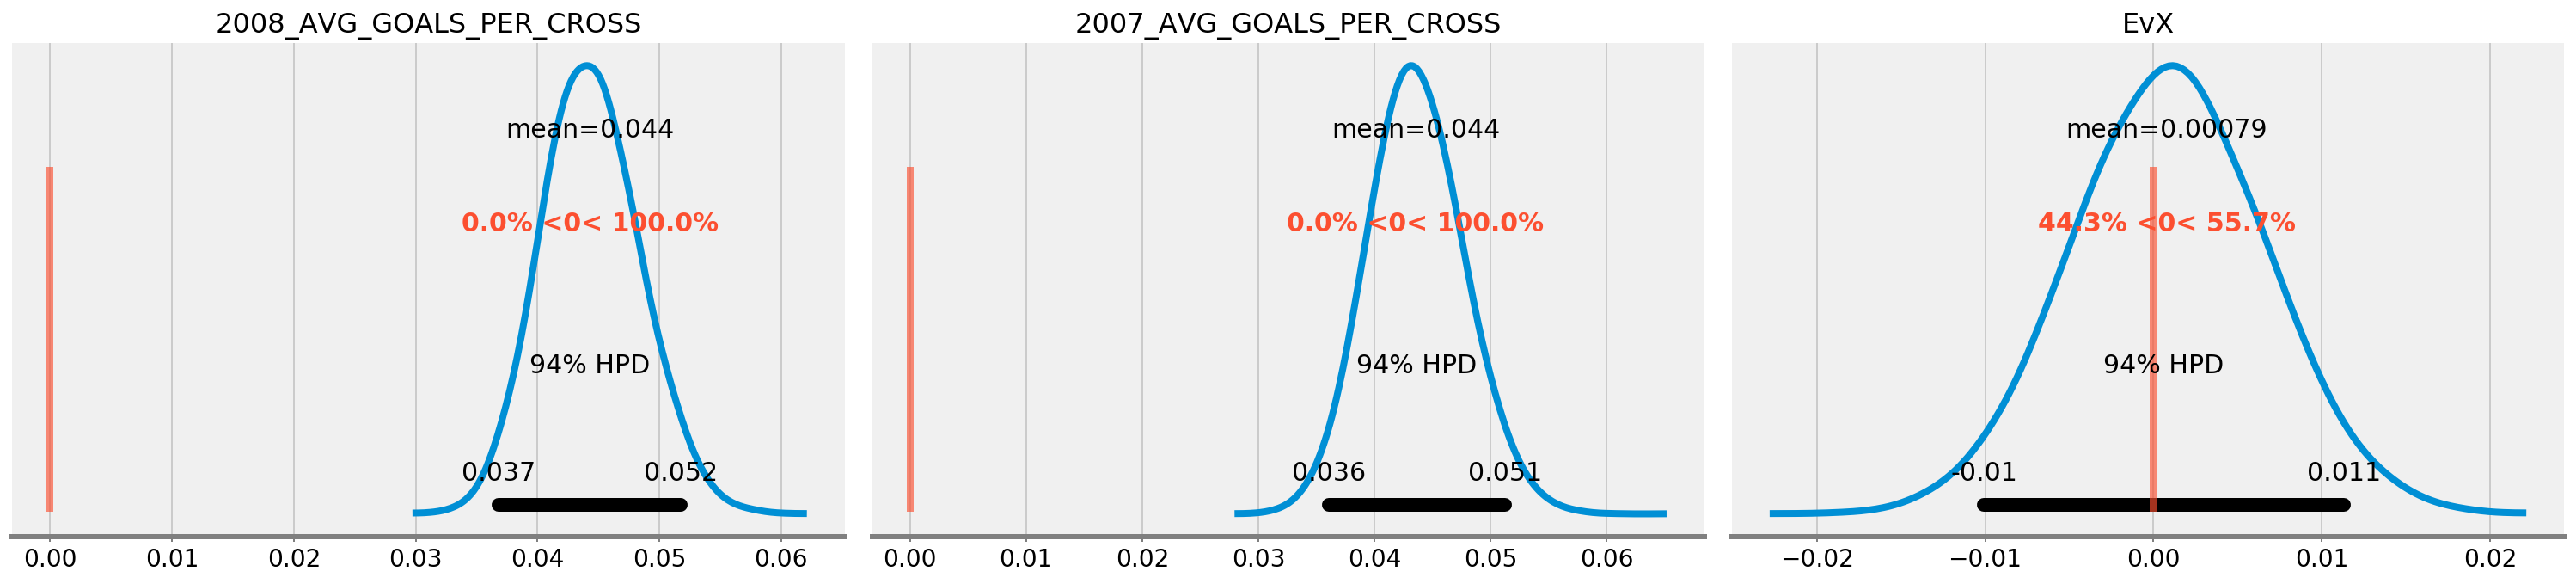

In [248]:
pm.plot_posterior(trace, var_names=['2008_AVG_GOALS_PER_CROSS','2007_AVG_GOALS_PER_CROSS','EvX'], ref_val=0)

In [249]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
2008_AVG_GOALS_PER_CROSS,0.044332,0.004001,0.000028,0.036659,0.052169,20186.621739,0.999981
2007_AVG_GOALS_PER_CROSS,0.043542,0.004042,0.000029,0.035783,0.051608,20248.622884,1.000029
EvX,0.000790,0.005684,0.000037,-0.010413,0.011869,20464.992749,0.999956


### Conclusion

I can see that Fulham had a better cross conversion ratio (to goals) in 2008 than in 2007. Interestingly they still happened to lose more games in 2008 (18 losses) than in 2007 (15 losses) ...oh well...